<a href="https://colab.research.google.com/github/gtareque/dataWrangling/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Code Author:**
*   Azim Murad
*   G M Asif Tareque
*   MH Jawad
*   Last Modified: 26/09/2019





In [ ]:
#All Import Statements go here
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer,StandardScaler,PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score, mutual_info_score
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from itertools import product
from string import ascii_lowercase
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
# Datasets
amazon_csv = "https://raw.githubusercontent.com/intexbackupa2z/Project-2/master/amazon(1).csv"
google_csv = "https://raw.githubusercontent.com/intexbackupa2z/Project-2/master/google(1).csv"
amazon_google_truth_csv = "https://raw.githubusercontent.com/intexbackupa2z/Project-2/master/amazon_google_truth(1).csv"
amazon_small_csv = "https://raw.githubusercontent.com/intexbackupa2z/Project-2/master/amazon_small(1).csv"
google_small_csv = "https://raw.githubusercontent.com/intexbackupa2z/Project-2/master/google_small(1).csv"
amazon_google_truth_small_csv = "https://raw.githubusercontent.com/intexbackupa2z/Project-2/master/amazon_google_truth_small(1).csv"
all_yeast_csv = "https://raw.githubusercontent.com/intexbackupa2z/Project-2/master/all_yeast(1).csv"

In [ ]:
# dataframes of all datasets
amazon = pd.read_csv(amazon_csv)
google = pd.read_csv(google_csv)
amazon_google_truth = pd.read_csv(amazon_google_truth_csv)
amazon_small = pd.read_csv(amazon_small_csv)
google_small = pd.read_csv(google_small_csv)
amazon_google_truth_small = pd.read_csv(amazon_google_truth_small_csv)
all_yeast = pd.read_csv(all_yeast_csv)

# Part 1 - Data Linkage

## Naive Linkage

In [ ]:
# function to generate n grams

def two_grams(string): 
    # tokenizes strings to 2-grams
    ngrams = []
    for i in range(0, len(string)):
        if(i == 0):
            ngrams.append(" " + string[0])
        else:
            ngrams.append(string[i - 1: i + 1])
    ngrams.append(string[i] + " ")  # the last character + a space
    return ngrams
#-------------------------------------------

# function for jaccard index 
def jacard_similarity(s1, s2):
    s1 = s1.lower()
    s2 = s2.lower()
    ngrams1 = two_grams(s1)
    ngrams2 = two_grams(s2)
    intersection = set(ngrams1).intersection(set(ngrams2))
    union = set(ngrams1).union(set(ngrams2))
    score = len(intersection)/len(union)
    return score
#------------------------------------------------

# makes the link between matching data
def linking_data(amazon_df, google_df, true_matches, linkage):
    for A in amazon_df.T:
        threshold = 0.24
        amazon_id = amazon_df.T[A]["idAmazon"]
        for G in google_df.T:    
            sim = jacard_similarity(google_df.T[G]["name"],
                                    amazon_df.T[A]["title"])
            if sim >= threshold:
                linkage[amazon_id] = google_df.T[G]["idGoogleBase"]
                threshold = sim  
    
#----------------------------------------------
def confusion_matrix(amazon_df, true_matches, linkage):
    tp = tn = fp = fn = 0 
    for A in amazon_df.T:
        
        amazon_id = amazon_df.T[A]["idAmazon"]
        # Positive
        if amazon_id in linkage:
            if amazon_id in true_matches.index:
                #True Positive:
                if str(linkage[amazon_id]) == str(true_matches["idGoogleBase"]
                                                  [amazon_id]):
                    tp += 1
                #False positive
                if str(linkage[amazon_id]) != str(true_matches["idGoogleBase"]
                                                  [amazon_id]):
                    fp += 1
            if amazon_id not in true_matches.index:
                #false positive
                fp += 1

        # Negative
        if amazon_id not in  linkage:
            if amazon_id not in true_matches.index:
                tn += 1
            if amazon_id in true_matches.index:
                fn += 1
    
    print("True Positives",tp)
    print("False Positives",fp)
    print("True Negative", tn)
    print("False Negative",fn)
    recall = tp/(tp + fn)
    precision = tp/(tp + fp)
    print("Recall =",recall)
    print("precision =",precision)
    print("tp+fp+tn+fn =",tp+fp+tn+fn)
    
# function to find PR and RR
def evaluate_block_linking(amazon_df, true_matches, linkage):
    tp = tn = fp = fn = 0 
    for A in amazon_df.T:
        amazon_id = amazon_df.T[A]["idAmazon"]
        #Positive
        if amazon_id in linkage:
            if amazon_id in true_matches.index:
                #True Positive:
                if str(linkage[amazon_id]) == str(true_matches["idGoogleBase"][amazon_id]):
                    tp += 1
                #False positive
                if str(linkage[amazon_id]) != str(true_matches["idGoogleBase"][amazon_id]):
                    fp += 1
            if amazon_id not in true_matches.index:
                #false positive
                fp += 1

        #Negative
        if amazon_id not in  linkage:
            if amazon_id not in true_matches.index:
                tn += 1
            if amazon_id in true_matches.index:
                fn += 1
    n = fp+fn+tp+tn
    PC = tp/(tp+fn)
    RR = 1-(tp+fp)/n
    print("True Positives",tp)
    print("False Positives",fp)
    print("True Negatives", tn)
    print("False Negative",fn)
    print("PC: ", PC)
    print("RR:", RR)

In [ ]:
# Calling the functions for Naive Linkage
true_matches = amazon_google_truth_small.set_index("idAmazon")
linkage = {}  # dictionary to store the matching pairs in naive linkage
linking_data(amazon_small, google_small, true_matches, linkage)
confusion_matrix(amazon_small, true_matches,linkage)

True Positives 124
False Positives 16
True Negative 8
False Negative 0
Recall = 1.0
precision = 0.8857142857142857
tp+fp+tn+fn = 148


### Discussion
The jaccard index function was chosen as it is a token based function. The strings were tokenized to 2-grams. We also considered the fact that the names are not that large of a string which makes jaccard the ideal function. For threshold we experimented using a for loop with a value from 0 to 1 with intervals of 0.1 which showed 0.2 to 0.3 which showed the ideal result. Then the range was changed to 0.2 to 0.3 with interval of 0.01 and hence 0.24 was attained. The threshold dynamically changes after each iteration. Overall, the method has great precision with high number of True positives and 0 False negatives. 


## Blocking

In [ ]:
google = google.rename(columns = {"id":"idGoogleBase"})


In [ ]:
# removing gbp and conver to aud with the current rate of 1.83 as shown in google
for G in google.T:
    found = re.search('gbp', google.T[G]["price"])
    if(found):
        x = re.split(' ' , google.T[G]["price"])
        
        google.T[G]["price"] = float(x[0]) *  1.83
    

In [ ]:
google["price"] = google["price"].astype("float64")

In [ ]:
block = []
p = 0.0
while( p < 1000.0):
    block.append(p)
    p += 5

In [ ]:
linkage_blocks = {}
google_copy = google.copy()
for b in block:
    google_block = google[(google["price"] >= b)]
    google_block = google_block[(google_block["price"] < b + 5)]
    amazon_block = amazon[(amazon["price"] >= b)]
    amazon_block = amazon_block[(amazon_block["price"] < b + 5)]
    linking_data(amazon_block, google_block, amazon_google_truth , linkage_blocks)

KeyboardInterrupt: ignored

In [ ]:
evaluate_block_linking(amazon, amazon_google_truth.set_index("idAmazon"), linkage_blocks)

### Discussion
1. Blocking Method:
    1. Made blocks on "Price" in amazon and google
    2. Made blocks on 5AUD gaps in range 0 to 1000
    3. Price is the best feature to block as same product will have same price in both companies. Manufacturer had missing values. Blocking on the first character of names was considered but the RR was too low and accuracy was lower as well
        
          
2. Quality:
    1. The PC and the RR had moderate values for both 

# Part 2 - Classification

## Pre-processing

### Imputation

In [ ]:
mean_imputed = all_yeast.iloc[:, 1 : 9].values
median_imputed = all_yeast.iloc[:, 1 : 9].values

#preprocessing missing values
# replacing with mean
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(mean_imputed)
mean_imputed = imputer.transform(mean_imputed)
all_yeast_mean_impute = all_yeast.copy()
all_yeast_mean_impute.iloc[:, 1 : 9] = mean_imputed

#replacing with median 
imputer = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
imputer = imputer.fit(median_imputed)
median_imputed = imputer.transform(median_imputed)
all_yeast_median_impute = all_yeast.copy()
all_yeast_median_impute.iloc[:, 1 : 9] = median_imputed

#printing
display(all_yeast_mean_impute.describe())
display(all_yeast_median_impute.describe())

,Sample,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,742.500000,0.499349,0.499876,0.505848,0.264379,0.506921,0.007500,0.503816,0.279816
std,428.538213,0.131357,0.121945,0.199837,0.150286,0.091573,0.075683,0.153481,0.151736
min,1.000000,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,371.750000,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,742.500000,0.499349,0.490000,0.510000,0.230000,0.500000,0.000000,0.510000,0.220000
75%,1113.250000,0.562500,0.570000,0.550000,0.300000,0.500000,0.000000,0.530000,0.290000
max,1484.000000,1.000000,1.000000,7.501819,3.000728,3.500849,0.830000,6.001456,4.501092


,Sample,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,742.500000,0.497628,0.499643,0.506167,0.260432,0.506739,0.007500,0.504199,0.276712
std,428.538213,0.131472,0.121954,0.199840,0.150817,0.091580,0.075683,0.153488,0.152315
min,1.000000,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,371.750000,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,742.500000,0.480000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,1113.250000,0.562500,0.570000,0.550000,0.300000,0.500000,0.000000,0.530000,0.290000
max,1484.000000,1.000000,1.000000,7.501819,3.000728,3.500849,0.830000,6.001456,4.501092


 #### Discussion
Imputation by median would be a better option to go with in this dataset due to the existence of outliers. From the data frame we can see that columns mcg ,gvh, alm, mit, erl, vac, nuc has NaN values. If we check the description of these columns we can see that most of these columns have very high maximum values as compared to the means. This implies that our means will be affected by these high figures and as a result it would not be a great idea to replace the missing figures by mean. Instead using median will ensure that middle most values will be filled where we have missing figures, hence providing better results. 



### Scaling

In [ ]:
#scaling
# by standardisation
yeast_median_impute_stand = all_yeast_median_impute.copy()
sc_median_imputed = StandardScaler()
X_stand = sc_median_imputed.fit_transform(median_imputed)
yeast_median_impute_stand.iloc[:, 1 : 9] = X_stand

In [ ]:
# by mean-centering
yeast_median_impute_cent = all_yeast_median_impute.copy()
yeast_median_impute_cent.iloc[:,1:9] = yeast_median_impute_cent.iloc[:,1:9].subtract(yeast_median_impute_cent.iloc[:,1:9].mean())

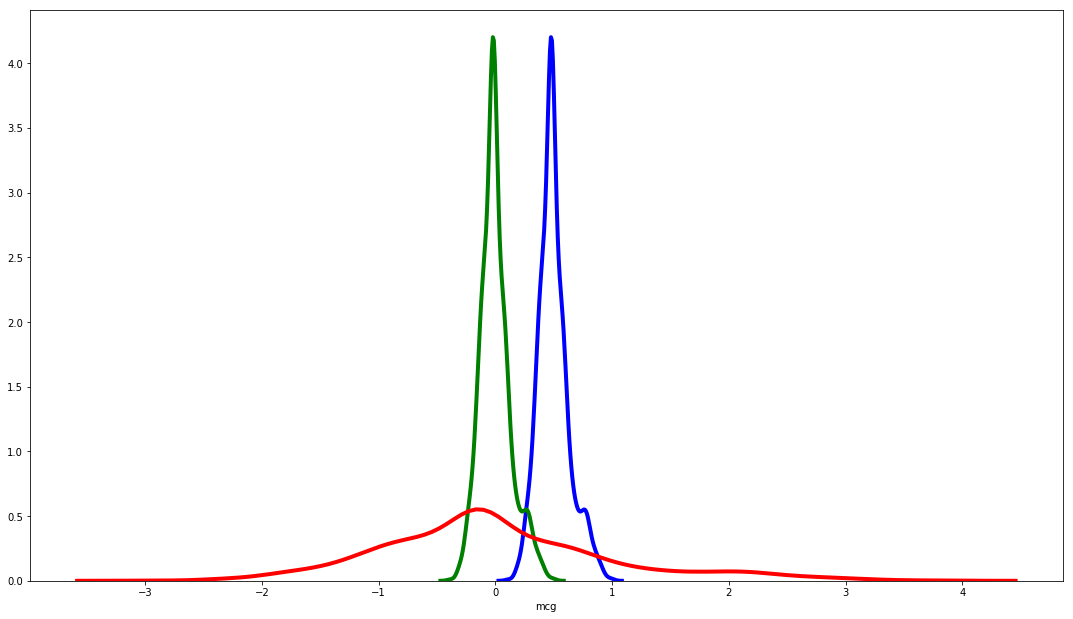

In [ ]:
import seaborn as sns
import matplotlib
sns.distplot(all_yeast_median_impute["mcg"], hist=False, kde=True, 
            bins=int(180/5), color = 'blue',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4})
sns.distplot(yeast_median_impute_cent["mcg"], hist=False, kde=True, 
            bins=int(180/5), color = 'green',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4})
sns.distplot(yeast_median_impute_stand["mcg"], hist=False, kde=True, 
            bins=int(180/5), color = 'red',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4})

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)


## Comparing Classification Algorithms

### KNN 5

In [ ]:

##get just the features
data=yeast_median_impute_cent[['mcg','gvh','alm','mit','erl','pox','vac','nuc']].astype(float)

##get just the class labels
classlabel=yeast_median_impute_cent['Class']

#splitting data into training and test set
##randomly select 66.67% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(data,classlabel, train_size=2/3, test_size=1/3, random_state = 44)

## Setting n = 5 
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred=knn.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.7191919191919192


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7353535353535353


###  KNN 10

In [ ]:
## n = 10 

knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred=knn.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.703030303030303


### Decision Tree

In [ ]:
## Decision Tree Algorithams.
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=7)
dt.fit(X_train, y_train)

y_pred=dt.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.6727272727272727


### Discussion

K-Neighbours Classifier with n = 5 produces the highest accuracy of 71.92. The Data all_yeast  
      Divided into training and test set in ratio of 2/3 to 1/3. Where 2/3 of data is used for training  
      The K-Neighbours Classifier and the rest of 1/3 data is used for testing, where the classifier   
      Predicts the class type based on eight given features. According to the experiments we can
      Clearly see that the accuracy of this prediction is better when we use N_Neighbours = 5 rather 
      Then 10. Even though large values of k in K-Neighbour classifier leads to minimisation of error 
      Error rate but at the same time choosing higher k leads to less-distinct bounderies among  
      Classes hence this could be the reason why k = 5 leads to better results rather then
      K = 10. Secondly we have also used decision tree classifier to predict class types, in this case 
      Data set has 8 different attributes and as result the tree and nodes become more complex
      Hence resulting in a lower accuracy result. Hence it can be concluded that n = 5    neighbourhood is   
      The best measure of accuracy in this case.

In [ ]:
yeast_median_impute_cent.head()

,Sample,mcg,gvh,alm,mit,erl,pox,vac,nuc,Class
0,1,0.082372,0.110357,-0.036167,-0.130432,-0.006739,-0.0075,-0.024199,-0.056712,non-CYT
1,2,-0.067628,0.170357,-0.026167,0.009568,-0.006739,-0.0075,0.025801,-0.056712,non-CYT
2,3,0.142372,0.120357,-0.016167,-0.110432,-0.006739,-0.0075,0.025801,-0.056712,non-CYT
3,4,0.082372,-0.059643,0.063833,-0.130432,-0.006739,-0.0075,0.035801,-0.056712,non-CYT
4,5,-0.077628,-0.059643,-0.026167,0.279568,-0.006739,-0.0075,-0.024199,-0.056712,non-CYT


LR: 0.674469 (0.129796)
LDA: 0.678523 (0.135869)
KNN: 0.664357 (0.088540)
CART: 0.669826 (0.055877)
NB: 0.594436 (0.106719)
SVM: 0.687960 (0.141496)


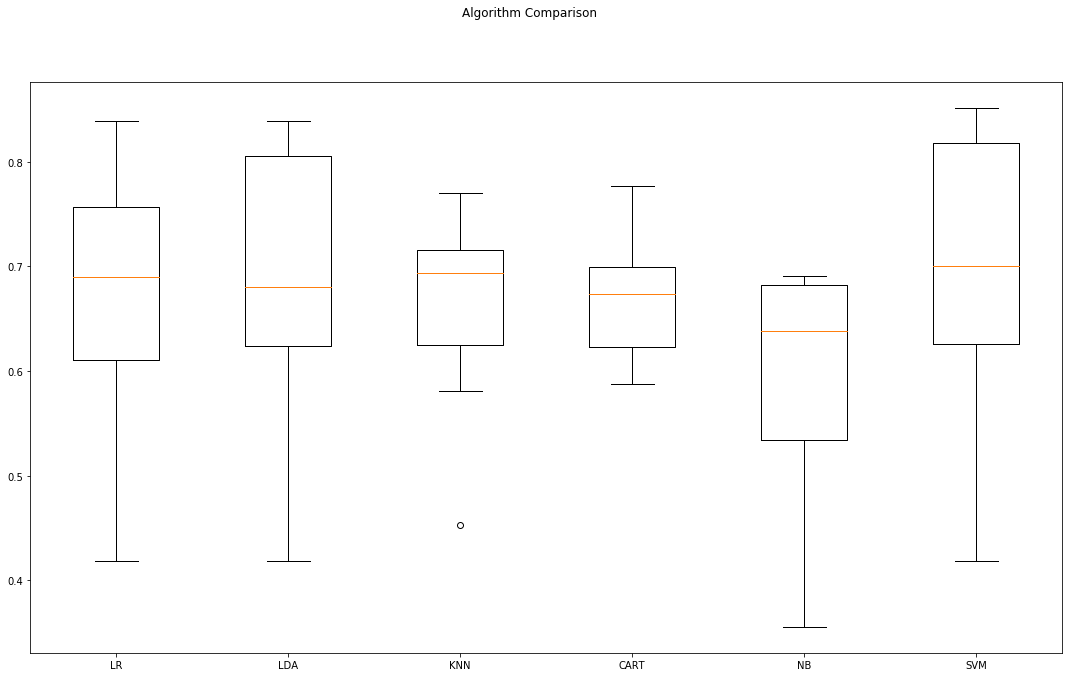

In [ ]:
e# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
dataframe = yeast_median_impute_cent
array = dataframe.values
X = array[:,1:9]
Y = array[:,9]
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
# plt.show()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

## Feature Engineering

### Interaction term pairs.

In [ ]:
# Polynomial featuring done here

median_imputed_polynom = all_yeast_median_impute.copy()
median_imputed_polynom = median_imputed_polynom.drop('Sample', axis = 1).drop('Class', axis = 1)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
polynomial_data = poly.fit_transform(median_imputed_polynom)


In [ ]:
#building the new dataframe here

orignal_attributes = median_imputed_polynom.columns.tolist() # column headings
new_attributes = ['mcggvh','mcgalm','mcgmit','mcgerl','mcgpox','mcgvac','mcgnuc','gvhalm','gvhmit','gvherl','gvhpox','gvhvac','gvhnuc','almmit','almerl','almpox','almvac','almnuc','miterl','mitpox','mitvac','mitnuc','erlpox','erlvac','erlnuc','poxvac','poxnuc','vacnuc']
new_columns = orignal_attributes + new_attributes

all_features = pd.DataFrame(data = polynomial_data , columns = new_columns)

In [ ]:
all_features_norml = all_features.subtract(all_features.mean())
X_train, X_test, y_train, y_test = train_test_split(all_features_norml,classlabel, train_size=0.66, test_size=0.34, random_state=44)

In [ ]:
MI = {}                                                                         
for f in all_features_norml:                                                    
    MI[f] = mutual_info_score(X_train[f], y_train)                              
MI = pd.Series(MI)                                                              

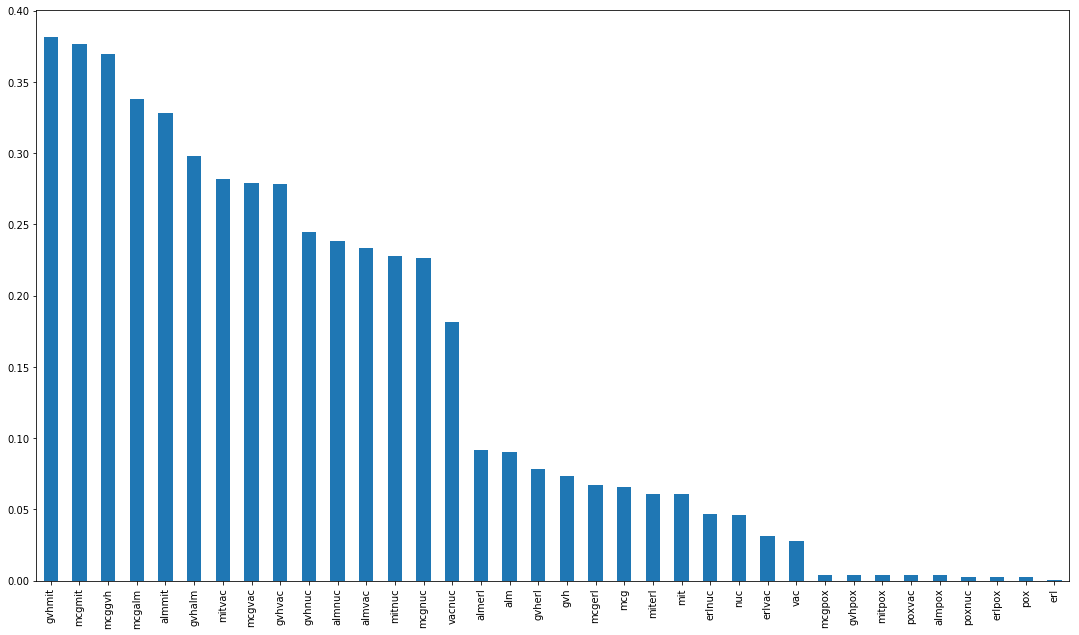

In [ ]:
MI.sort_values(ascending = False, inplace=True)
MI.plot.bar()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

In [ ]:
# https://stackoverflow.com/questions/15821116/how-to-measure-the-accuracy-of-knn-classifier-in-python
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train[MI.nlargest(15).index], y_train)
y_pred=knn.predict(X_test[MI.nlargest(15).index])

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.7366336633663366
              precision    recall  f1-score   support

         CYT       0.57      0.47      0.52       151
     non-CYT       0.79      0.85      0.82       354

    accuracy                           0.74       505
   macro avg       0.68      0.66      0.67       505
weighted avg       0.73      0.74      0.73       505

[[ 71  80]
 [ 53 301]]


In [ ]:
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,f1-score,precision,recall,support
CYT,0.516364,0.572581,0.470199,151.000000
non-CYT,0.819048,0.790026,0.850282,354.000000
accuracy,0.736634,0.736634,0.736634,0.736634
macro avg,0.667706,0.681303,0.660241,505.000000
weighted avg,0.728542,0.725008,0.736634,505.000000


In [ ]:
# https://gist.github.com/nickynicolson/202fe765c99af49acb20ea9f77b6255e
from sklearn.metrics import confusion_matrix
import pandas as pd

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

# to use, first generate confusion matrix:
cm = confusion_matrix(y_test, y_pred)
# then convert to pandas DataFrame:
cm_as_df=cm2df(cm,["CYT","non-CYT"])
# and output:
cm_as_df

,CYT,non-CYT
CYT,71,80
non-CYT,53,301


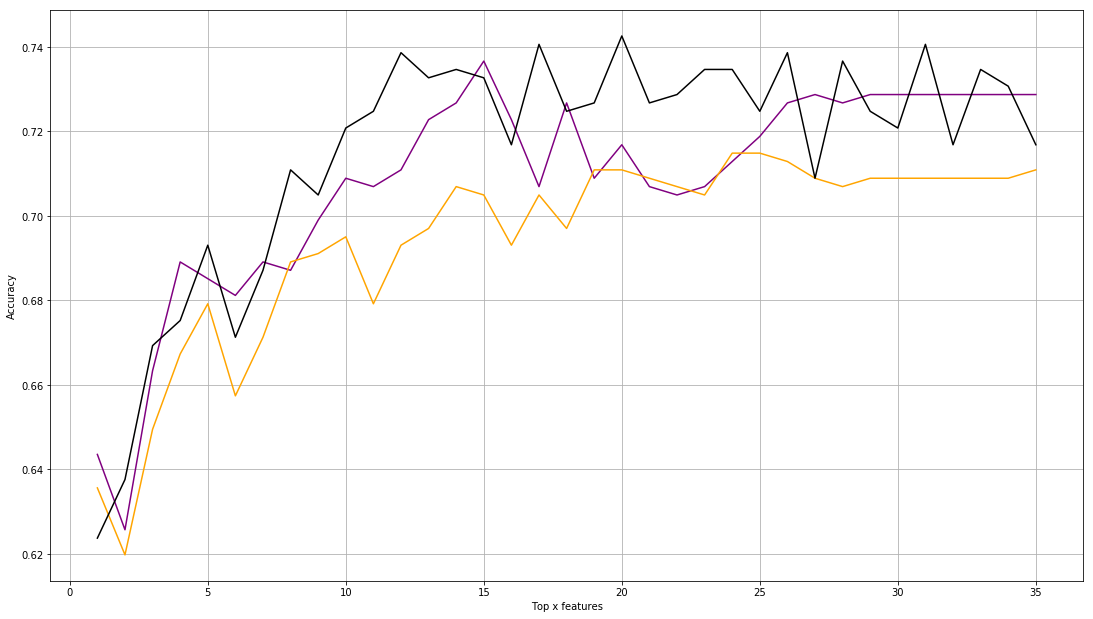

In [ ]:
feat = []
k_5 = []
k_10 = []
rf = []

for i in range(1,36):
    
    feat.append(i)
    knn = neighbors.KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train[MI.nlargest(i).index], y_train)

    y_pred=knn.predict(X_test[MI.nlargest(i).index])
    k_5.append(accuracy_score(y_test, y_pred))

    knn = neighbors.KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train[MI.nlargest(i).index], y_train)

    y_pred=knn.predict(X_test[MI.nlargest(i).index])
    k_10.append(accuracy_score(y_test, y_pred))
    

    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=100, random_state = 0 )

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train[MI.nlargest(i).index], y_train)

    y_pred=clf.predict(X_test[MI.nlargest(i).index])

    # Model Accuracy, how often is the classifier correct?
    rf.append(metrics.accuracy_score(y_test, y_pred))
    
plt.plot(feat, k_5, color='purple')
plt.plot(feat, k_10, color='orange')
plt.plot(feat, rf, color = 'black')
plt.xlabel('Top x features')
plt.ylabel('Accuracy')
plt.grid()


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train[MI.nlargest(15).index], y_train)
y_pred=knn.predict(X_test[MI.nlargest(15).index])
print("For k = 5: ", accuracy_score(y_test, y_pred))


knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train[MI.nlargest(24).index], y_train)
y_pred=knn.predict(X_test[MI.nlargest(24).index])
print("For k = 10: ",accuracy_score(y_test, y_pred))

clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train[MI.nlargest(20).index], y_train)

y_pred=clf.predict(X_test[MI.nlargest(20).index])

# Model Accuracy, how often is the classifier correct?
print('rf accuracy:',metrics.accuracy_score(y_test, y_pred))



For k = 5:  0.7366336633663366
For k = 10:  0.7148514851485148
rf accuracy: 0.7386138613861386


In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train[MI.nlargest(15).index], y_train)

y_pred=clf.predict(X_test[MI.nlargest(15).index])

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7326732673267327


### Feature generation with clustering labels

In [ ]:
# performing Kmeans Clustering 

k5 = []
k10 = []

data= yeast_median_impute_cent[['mcg','gvh','alm','mit','erl','pox','vac','nuc']]
classlabel=all_yeast['Class']
X_train, X_test, y_train, y_test = train_test_split(data,classlabel, train_size=2/3, test_size=1/3, random_state=44)


for i in range(1,21):
    clustering = KMeans(n_clusters=i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    clustering.fit(X_train)

    ##adding f_cluster feature.
    X_train["clusters"] = clustering.labels_

    X_test["clusters"] = clustering.predict(X_test)

    ## Setting n = 5 
    knn = neighbors.KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    
    
    y_pred=knn.predict(X_test)
    k5.append(accuracy_score(y_test, y_pred))


    ## Setting n = 10 
    knn = neighbors.KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train, y_train)

    y_pred=knn.predict(X_test)
    k10.append(accuracy_score(y_test, y_pred))

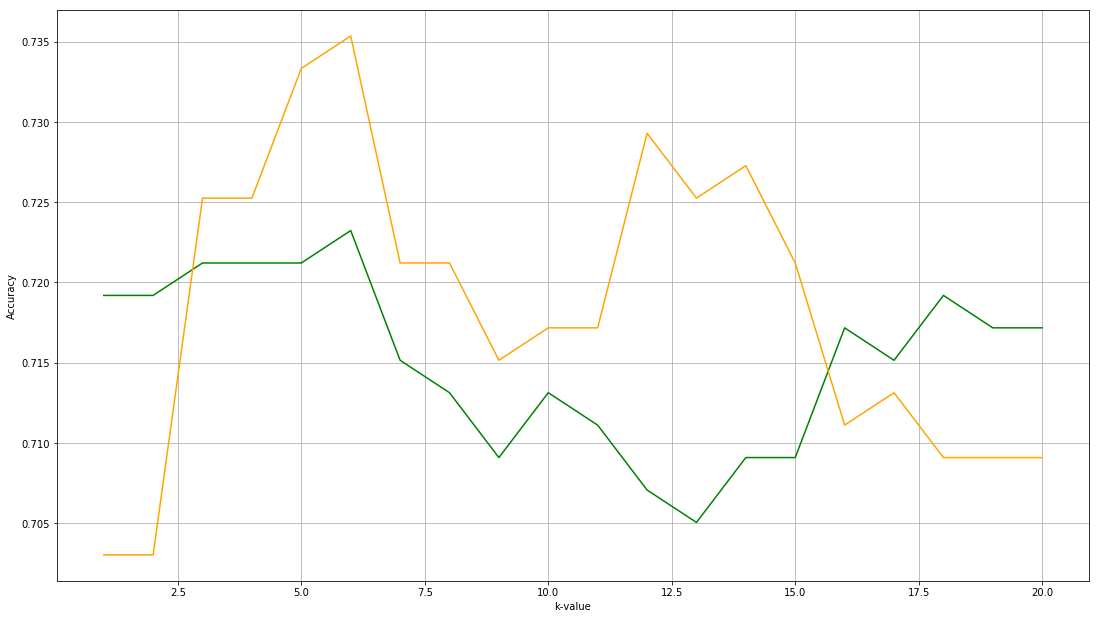

In [ ]:
plt.plot(list(range(1,21)), k5, color='g')
plt.plot(list(range(1,21)), k10, color='orange')
plt.xlabel('k-value')
plt.ylabel('Accuracy')
plt.grid()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

In [ ]:
#k5 = 6
print("kNN 5-Accuracy when 6 clusters:", k5[5])
#k10 = 6
print("kNN 10-Accuracy when 6 clusters:", k10[5])



kNN 5-Accuracy when 6 clusters: 0.7232323232323232
kNN 10-Accuracy when 6 clusters: 0.7353535353535353


### Discussion
1.   Parameters: 
    1. Interaction term pairs:
        * Parameter 
            * KNN=5 -> 15 Top features
            * KNN=10 -> 24 Top features
        * Reason: After experimenting different no. of top features and plotting the accuracies the above parameters produced highest accuracy
    
    2. Clustering labels:
        * Parameter 
            * KNN:5 -> 6 Clusters
            * KNN:10 -> 6 Clusters
        * Reason: After experimenting different cluster and plotting the accuracies the above parameters produced highest accuracy

    3. feature selection+generation: can produce a slightly better accuracies for KNN:5(2% increase) and KNN:10(1% increase)
    
    4. feature generation with clustering labels:can produce a slightly better accuracies for KNN:5(1% increase) and KNN:10(2% increase)

    Overall Both Methods don't increase the accuracy significantly